# Лабораторная работа №1. Реккурентные нейронные сети и слой Embedding.

**Выполнили:** Алёшина Арина, Базылева Алёна (15ФПЛ)

## Задача 1: Создание PoS-теггера

## Языки

**Нидерландский (голландский) язык** - аналитический язык, входит в нижненемецкую подгруппу западногерманской группы германской ветви индоевропейской языковой семьи. Официальный язык в Нидерландах, двух из трех регионов Бельгии (единственный официальный язык Фландрии и один из двух официальных языков Брюсселя), Суринаме, на Нидерландских Антильских о-вах и на Арубе.  
Нидерландский язык очень близок к английскому и немецкому языкам. Помимо того, что нидерландский язык, как и английский, не прошел в своем развитии стадию верхненемецкого сдвига согласных, он также отличается отсутствием системы грамматических падежей, относительной редкостью германского умлаута и довольно упорядоченной морфологией. Нидерландский язык известен активным использованием велярных фрикативных согласных. А с немецким языком его роднит несвободный порядок слов. 

**Словацкий язык** - флективный язык, входит в чехо-словацкую подгруппу западнославянской группы славянской ветви индоевропейской языковой семьи. Официальный язык Словацкой Республики. Очень близок к чешскому языку.
К особенностям словацкого языка относят такие фонетические черты, как наличие кратких и долгих гласных, а также восходящих дифтонгов; распространение ритмического закона; употребление долгих и кратких слогообразующих сонорных. Для словацкого языка характерна палатализация. Ударение в стандартном языке всегда падает на первый слог слова. Из присущих словацкому черт морфологии отмечаются такие, как наличие окончания -ovia у одушевлённых существительных в форме им. падежа мн. ч.; распространение окончания -m у всех глаголов наст. времени в форме 1-го лица единственного числа и др. Порядок слов в словацком языке относительно свободный.


In [2]:
from conllu import parse_incr
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import collections
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


Созданем множества токенов-"не-слов" (пунктуация, числа) для языков по доступу через словарь (с целью передать как переменную в класс)

In [3]:
no_words_slovak = {' ', '“', '!', '\"', '\'', '(', ')', '*', '+', ',', '-', '--', '.', '/', '00', '08', '09', '1', '10', '1031', '1037', '1038', '1039', '1044', '1046', '1050', '1052', '1054', '1057', '1060', '1071', '1076', '1083', '1091', '1092', '1093', '1095', '1096', '1097', '1098', '11', '1100', '1103', '12', '1220', '1226', '1230', '13', '14', '149', '15', '1543', '16', '17', '1773', '18', '1898', '19', '1903', '1917', '1935', '1941', '1948', '1956', '1960', '1962', '1963', '1966', '1968', '1973', '1977', '1989', '1990', '1992', '1995', '1999', '2', '20', '200', '2000', '2003', '2004', '2006', '21', '220', '28', '29', '294224', '3', '31', '39', '4', '40', '41', '5', '57', '6', '62', '7', '73', '8', '9', '99', ':', ';', '=', '?', 'Α'}
no_words_dutch = {' ', '“', '!', '!!!', '\"', '&', '\'', '\'\'', '\'38', '\'48', '\'52', '\'59', '\'60', '\'67', '\'68', '\'69', '\'70', '\'n', '\'s', '\'t', '(',  ')', ',', ',,', ',58', ',62', '-', '-1', '-3', '.', '..', '...', '....', '/', '0', '0,009', '0,10', '0,3', '0,4', '0,60', '0,80', '0,85', '0-0', '0-1', '0-2', '007', '040-12280', '1', '1,04', '1,11', '1,2', '1,20', '1,3', '1,40', '1,50', '1,7', '1,8', '1-', '1-0', '1-1', '1-2', '1-4', '1.', '1.000', '1.059', '1.14', '1.292', '1.3', '1.404.796,50', '1.405', '1.50', '1.700', '1.75', '1/2', '1/3', '1/4', '1/8', '10', '10,-', '10,95', '10-0', '10-15', '10.000', '10.000,-', '10.1', '10.8', '10.9', '100', '100,80', '100.000', '100.000,-', '100.10', '100.80', '1000', '10000', '101', '101,40', '102', '1020', '10266', '1030', '105', '107.500', '109,2', '10980', '11', '11,4', '11-1', '11.-', '11.000', '11.18', '11.47', '11.990', '110', '111', '112.30', '112.90', '113', '113.50', '113.60', '114', '115.000', '1167453', '1170', '118,90', '11892', '12', '12,8', '12,80', '12-11', '12-15', '12-8', '12.500', '12.65', '120', '120.000', '1200', '1212', '123', '123.000', '125,-', '125,00', '125.000', '126.431,68', '127', '13', '13-7', '13.000', '13.080', '13.20', '13.25.8', '13.300', '130', '130.000', '130.000,-', '1300', '131', '13126', '1349', '14', '14,80', '14.000', '14.133', '14.15', '140', '140.000', '1415', '142', '142,40', '14252', '143', '145', '145.20', '145.40', '147', '147,40', '147.000', '1473', '1486', '15', '15,16', '15,4', '15-5', '15-6', '15-9', '15-jarig', '15.00', '15.098', '15.200', '15.3017.20', '150', '1500', '1500,-', '1500-1540', '1529', '153', '153.237', '153.940', '1533', '1534', '1536', '1572', '1584', '159', '16', '16,47', '16.000', '16.57,3', '16.6', '160', '1605', '162.40', '1620', '16327', '1637', '164', '164.80', '1668', '167.000', '168', '1689', '17', '17,5', '17.00', '17.05', '17.17', '17.23', '17.657', '170', '1700', '1721', '1725', '1738', '1751', '1759', '17660', '177', '1773', '179', '1791', '1792', '1797', '18', '18,', '18,4', '18,9', '18-21', '18-22', '18.000', '18.335', '18.500', '180.000', '1800', '1828', '1830', '1831', '1841', '1846', '1847', '1848', '185', '1851', '1855', '1860', '1870', '1871', '1874', '1881', '1887', '189.647,53', '1890', '1890-1964', '1896', '1899', '1899-1900', '19', '19,8', '19.00', '19.04', '19.15', '19.55', '1900', '1904', '1905', '1912', '1913', '1915', '1916', '1917', '1918', '1920', '1922', '1924', '1926', '1927', '1928', '1929', '1930', '1932', '1933', '1935', '1937', '1938', '1939', '1940', '1941', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1952', '1953', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '19631965', '1964', '1965', '1966', '1967', '1967-1968', '1968', '1968-\'69', '1969', '1969-1970', '1970', '1970-1971', '1971', '1971-1975', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '198.000', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '199', '1990', '1991', '1992', '1993', '1994', '1994-1991', '1994-1995', '1995', '1996', '1997', '1998', '1999', '2', '2,00', '2,5', '2,50', '2,8', '2,80', '2,95', '2-', '2-0', '2-1', '2-2', '2-3', '2-5', '2-6', '2.', '2.09.6', '2.10,6', '2.10,9', '2.13.0', '2.31', '2.392', '2.4', '2.500', '2.70', '2.800', '2.937', '20', '20.000', '20.000,-', '20.20', '20.30', '200', '200.000', '2000', '20000', '2001', '2002', '2003', '2004', '2005', '2008', '204', '208', '21', '21,3', '21.00', '21.20', '21.35', '21.45', '21000', '2102', '2135', '2140', '22', '22,1', '22.15', '22.35', '22.55', '2220-2240', '23', '23,38', '23.20', '230', '2310', '232', '238', '24', '24-30', '24.600,-', '240', '24000', '241', '242.5', '25', '25,-', '25.000', '250', '2500', '255', '255.000', '258.3', '26', '26-24', '260', '260.000', '2600', '2657', '27', '27.000', '2700', '2792', '28', '2850', '29', '2907', '295', '2x', '3', '3,2', '3,5', '3,50', '3-', '3-0', '3-1', '3-2', '3-4', '3.', '3.000', '3.5', '3/10', '3/4', '30', '30.000', '30.000,-', '300', '3000', '3000,-', '304', '3042', '31', '31.200', '32', '32.000', '322.000', '33', '333', '338,4', '33jarig', '34', '34.109', '35', '350', '3500', '354', '359.000', '36', '36-a', '36.000', '360', '361', '366', '369', '37,7', '37.974', '38', '38,8', '380', '384', '39', '397', '3b', '4', '4,2', '4,20-32', '4,4', '4,50', '4,6', '4,61', '4,7', '4,75', '4-0', '4-1', '4-2', '4-6', '4.139', '4.31', '4.49.6', '4.50,5', '4.51,1', '40', '40.000', '40.000,-', '400', '400.000', '4000', '405.000', '41', '4102', '414', '419', '42', '42.000', '424', '425', '43', '433005041', '437', '438', '44', '45', '45.000', '450', '450.000', '453', '453.000', '454', '46', '47', '47,5', '47-jarig', '47/1', '47/2', '475,-', '476.920', '48', '49', '49.964', '4900', '5', '5,-', '5,1144', '5,2', '5,2496', '5,45', '5,50', '5,74', '5-0', '5-4', '5-5', '5.000', '5.000,-', '5.001', '5.4', '5.500', '5.500,-', '5.574,-', '5.670,-', '5/8', '50', '50,2', '50-jarige', '50.000', '500', '500.000', '5000', '501', '50cc', '51', '51-70', '51.000', '512', '52', '5212', '53', '54', '54,3', '54.', '54.000', '540', '55', '55.000', '55.30', '5500', '56', '57', '57,2', '57,3', '570', '58', '59', '595', '5x', '6', '6,00', '6,53', '6,85', '6-0', '6-1', '6-3', '6-4', '6.05', '6.225', '6.584,-', '6.680,-', '60', '60-48', '60.000', '60.000,-', '600', '602', '61', '61-56', '61.000', '6100', '62', '62.000,-', '620', '6200', '63', '632.158,50', '64', '64,70', '65', '650', '66', '668.346', '67', '68', '685.000', '69', '7', '7,5', '7,50', '7,6', '7,75', '7-0', '7-9', '7.000', '7.008', '7.268,-', '7.364,-', '70', '70.000', '700', '709.000', '71', '716.11', '718345', '72', '725.000', '73', '74', '75', '76', '78', '78-jarig', '780', '7800', '797', '8', '8,6', '8-0', '8-15', '8.4', '80', '80-jarige', '80.000', '800', '800-metertijd', '800.000', '8000', '80000', '81', '82', '82,50', '835.000', '84', '85', '85-70', '851', '868', '870', '870.002', '88', '880', '888', '89', '9', '9,3', '9,7', '9,78', '9,9', '9.000', '9.90', '90', '900', '900.000', '908', '917', '92', '92,50', '924', '93', '93,5', '9336', '94', '945', '96', '96.50', '965', '98', '98,60', '98,80', '98.20', '985', '99', '99,70', '99.90', '990', ':', ';', '=', '?'}
no_words_dict = {'Slovak': no_words_slovak, 'Dutch': no_words_dutch}

Класс для работы с токенами и подсчета статистики.  
Возможно, реализация выглядит несколько громоздко, но все это объясняется особенностью корпусов UD и conllu файлов для выбранных языков (долго искали решение для адекватной обработки файлов)

In [49]:
class Get_Stats:
    unique_tkns = set()
    lang = None # Наименование языка
    word = None # Множество слов
    word_cnt = None # Массив NUMPY
    word_freqs = None # Коллекция
    word_freqs_full = None # Коллекция
    tag_freqs = None # Коллекция
    word_tag_freqs = None # Коллекция
#    max_word_len = 0 # int
    
    def __init__(self, lang, way, nw_set, ds_type='train', param="r", encoding="utf-8"):
        self.way = way
        self.lang = lang
        self.ds_type = ds_type        
        ftrain = open(way, param, encoding=encoding)
        self.word_freqs = collections.Counter()
        self.word_freqs_full = collections.Counter()
        self.tag_freqs = collections.Counter()
        self.word_tag_freqs = collections.Counter()
        self._iter_token(ftrain, nw_set)
        self.description()
        self.histograms()
        del nw_set
        
    def _iter_token(self, file, nw_set):
        tokenlist = parse_incr(file)
        with open('Data\\_temp\\' + self.lang + '_' + self.ds_type + '_Simple_RNN.txt', 'w', encoding='utf-8') as g:
            for form in self._stats(tokenlist, nw_set):
                g.write(form)
        
    def _stats(self, tokenlist, nw_set):
        word_cnt_ = []
        word_cnt_full_ = []
        tkn_cnt_ = []
        word_ = set()
        for num_tkn, tkn in enumerate(tokenlist):
            tkn_cnt_.append(len(tkn))
            no_word = 0
            for num_word, word in enumerate(tkn):
                wrd = None
                self.unique_tkns.add(word['lemma'])
                self.word_freqs_full[word['lemma']] += 1
                if not str(word['lemma']) in nw_set: 
                    self.word_freqs[word['lemma']] += 1
                    self.tag_freqs[word['upostag']] += 1
                    self.word_tag_freqs[(word['lemma'], word['upostag'])] += 1
                    wrd = ' ' + word['lemma']
                else:
                    no_word += 1
                    wrd = word['lemma']
                yield wrd
            word_cnt_.append(len(tkn) - no_word)
            word_cnt_full_.append(len(tkn))
            self.word_cnt, self.word = np.array(word_cnt_full_), set(self.word_freqs)
            self.nb_chars = len(self.word)
            
    def description(self):
        print(self.lang, '-', self.ds_type)
        print('a. Число предложений / уникальных словоформ:', len(self.word_cnt), '/', len(self.word_tag_freqs))
        print('b. Число уникальных PoS-тегов:', len(self.tag_freqs))
        print('c. Максимальное число слов в предложении:', self.word_cnt.max(), '/ минимальное:', self.word_cnt.min())
        print('d. Математическое ожидание числа слов в предложении:', round(np.mean(self.word_cnt), 2), '/ медиана:', round(np.median(self.word_cnt), 2))
    
    def histograms(self):
        
        x = [self.tag_freqs[item] for item in self.tag_freqs.keys()]
        plt.bar(self.tag_freqs.keys(), self.tag_freqs.values(), width='1.2' 'g', align='center')
        plt.xlabel('Tags')
        plt.ylabel('Frequency')
        plt.title('PoS-tags Histogram')
        plt.show()
        print(' '.join(list(self.tag_freqs.keys())))  #более удобная подпись тегов из гистограммы

Slovak - train
a. Число предложений / уникальных словоформ: 8483 / 10899
b. Число уникальных PoS-тегов: 16
c. Максимальное число слов в предложении: 46 / минимальное: 2
d. Математическое ожидание числа слов в предложении: 9.5 / медиана: 8.0


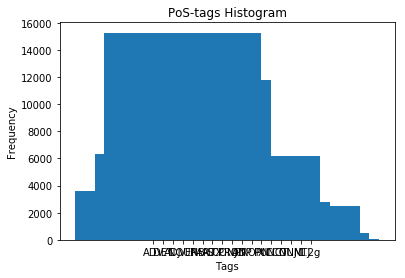

ADV DET ADJ NOUN VERB PART AUX SCONJ PRON ADP PROPN X PUNCT CCONJ NUM INTJ

Slovak - test
a. Число предложений / уникальных словоформ: 1061 / 3955
b. Число уникальных PoS-тегов: 16
c. Максимальное число слов в предложении: 54 / минимальное: 2
d. Математическое ожидание числа слов в предложении: 12.28 / медиана: 11.0


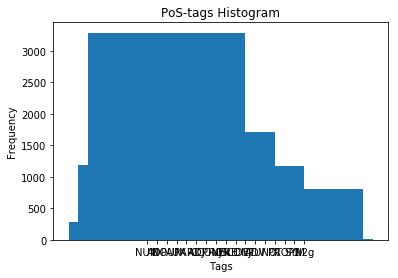

NUM ADP NOUN AUX PART ADJ CCONJ PRON VERB SCONJ DET ADV PUNCT X PROPN SYM
e. Доля новых (не встреч-ся в тренировочной выборке) слов в тестовой выборке: 0.0411


In [48]:
SLOVAK_TRAIN = Get_Stats(lang='Slovak', 
                         way="Data\\Input\\Slovak\\UD_Slovak-SNK\\sk_snk-ud-train.conllu",
                         nw_set=no_words_dict['Slovak'], 
                         ds_type='train')
print()
SLOVAK_TEST = Get_Stats(lang='Slovak', 
                        way="Data\\Input\\Slovak\\UD_Slovak-SNK\\sk_snk-ud-test.conllu",
                        nw_set=no_words_dict['Slovak'], 
                        ds_type='test')
a1, b1 = SLOVAK_TEST.word, SLOVAK_TRAIN.word
print('e. Доля новых (не встреч-ся в тренировочной выборке) слов в тестовой выборке:', 
      round(sum(tuple(map(lambda x: SLOVAK_TEST.word_freqs[x], a1.difference(b1)))) / 
      sum(SLOVAK_TRAIN.word_freqs.values()), 4))

Dutch - train
a. Число предложений / уникальных словоформ: 12269 / 21087
b. Число уникальных PoS-тегов: 16
c. Максимальное число слов в предложении: 74 / минимальное: 1
d. Математическое ожидание числа слов в предложении: 15.17 / медиана: 12.0


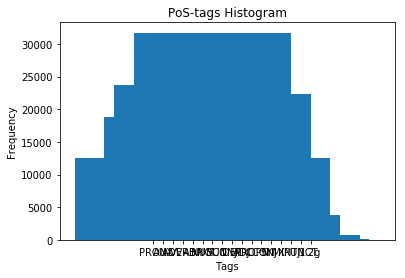

PRON AUX ADV VERB ADP NUM NOUN SCONJ DET ADJ PROPN CCONJ SYM X INTJ PUNCT

Dutch - test
a. Число предложений / уникальных словоформ: 596 / 2477
b. Число уникальных PoS-тегов: 15
c. Максимальное число слов в предложении: 68 / минимальное: 1
d. Математическое ожидание числа слов в предложении: 18.55 / медиана: 17.0


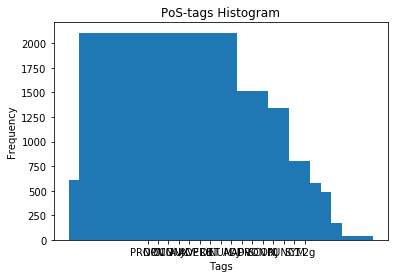

PROPN NOUN CCONJ AUX ADP VERB DET NUM ADJ ADV PRON SCONJ X PUNCT SYM
e. Доля новых (не встреч-ся в тренировочной выборке) слов в тестовой выборке: 0.0073


In [50]:
DUTCH_TRAIN = Get_Stats(lang='Dutch', 
                        way="Data\\Input\\Dutch\\UD_Dutch-Alpino\\nl_alpino-ud-train.conllu",
                        nw_set=no_words_dict['Dutch'], 
                        ds_type='train')
print()
DUTCH_TEST = Get_Stats(lang='Dutch', 
                       way="Data\\Input\\Dutch\\UD_Dutch-Alpino\\nl_alpino-ud-test.conllu",
                       nw_set=no_words_dict['Dutch'], 
                       ds_type='test')
a2, b2 = DUTCH_TEST.word, DUTCH_TRAIN.word
print('e. Доля новых (не встреч-ся в тренировочной выборке) слов в тестовой выборке:', 
      round(sum(tuple(map(lambda x: DUTCH_TEST.word_freqs[x], a2.difference(b2)))) / 
      sum(DUTCH_TRAIN.word_freqs.values()), 4))

In [6]:
SLOVAK_MAX_SEQLEN = 54
SLOVAK_S_MAX_FEATURES = 4000
SLOVAK_T_MAX_FEATURES = 16  

DUTCH_MAX_SEQLEN = 74
DUTCH_S_MAX_FEATURES = 3000
DUTCH_T_MAX_FEATURES = 16

Функция для построения тензора:

In [8]:
def build_tensor(sents, numsents, toindex, maxlen):
    data = np.empty((numsents, ), dtype=list)
    i = 0
    for line in sents:
        wids = []
        for word in line:
            if word in toindex:
                wids.append(toindex[word])
            else:
                wids.append(toindex['UNK'])
        data[i] = wids
        i += 1
    pdata = sequence.pad_sequences(data, maxlen=maxlen, padding='post', truncating="post")
    return pdata

## Голландский язык

Согласно собранной статистике, MAX_SEQLEN для голландского языка = 74, но маловероятно, что многие предложения действительно имеют такую большую длину. Скорее всего, предложение в 74 слова - единичный случай, поэтому немного урежем DUTCH_MAX_SEQLEN, что не должно сильно сказаться на качестве модели, но несколько увеличит скорость обучения

In [10]:
DUTCH_MAX_SEQLEN = 60
DUTCH_S_MAX_FEATURES = 3000
DUTCH_T_MAX_FEATURES = 16

Генерируем таблицы соответствия слов и тегов с их индексами

In [11]:
dt_word2index = {w[0]: i + 2 for i,w in enumerate(DUTCH_TRAIN.word_freqs.most_common(DUTCH_S_MAX_FEATURES))}
dt_word2index['PAD'] = 0
dt_word2index['UNK'] = 1
dt_tag2index = {t: i + 1 for i,t in enumerate(DUTCH_TRAIN.tag_freqs)}
dt_tag2index['PAD'] = 0

In [12]:
DUTCH_S_MAX_FEATURES += 2
DUTCH_T_MAX_FEATURES += 1

Собираем все последовательности и все возможные теги для тренировочных и тестовых данных

In [13]:
def get_all_sents(filename):
    all_sents = []
    all_tags = []
    data = open(filename, 'r', encoding='utf8')
    for sents in parse_incr(data):
        tag = []
        sent = []
        for word in sents:
            sent.append(word['form'].lower())
            tag.append(word['upostag'])
        all_sents.append(sent)
        all_tags.append(tag)
    return all_sents, all_tags

In [14]:
dt_train_sents, dt_train_tags = get_all_sents('Data\\Input\\Dutch\\UD_Dutch-Alpino\\nl_alpino-ud-train.conllu')
dt_test_sents, dt_test_tags = get_all_sents('Data\\Input\\Dutch\\UD_Dutch-Alpino\\nl_alpino-ud-test.conllu')

Строим тренировочные и тестовые тензоры и разделяем тренировочные данные на собственно тренировочную и валидационную выборки

In [15]:
X = build_tensor(dt_train_sents, len(dt_train_sents), dt_word2index, DUTCH_MAX_SEQLEN)
Xtest = build_tensor(dt_test_sents, len(dt_test_sents), dt_word2index, DUTCH_MAX_SEQLEN)
Y = build_tensor(dt_train_tags, len(dt_train_sents), dt_tag2index, DUTCH_MAX_SEQLEN)
Ytest = build_tensor(dt_test_tags, len(dt_test_sents), dt_tag2index, DUTCH_MAX_SEQLEN)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [16]:
# y - ожидаемые (правильные) теги
# h - предсказанные теги
def evaluate(y, h, test_tags):
    new_y = []
    new_h = []
    for line in y:
        k = 0
        for i in range(len(test_tags[k])):
            new_y.append(line[i])
        k+=1
    for line in h:
        k = 0
        for i in range(len(test_tags[k])):
            new_h.append(line[i])
        k+=1
        
    classes = set(new_y)
    len_new_y = len(new_y)
    results = {'accuracy w/o paddings': 0}
    class_dist = {c: new_y.count(c) / len_new_y for c in classes}

    for c in classes:
        tp = set()
        fp = set()
        tn = set()
        fn = set()

        for i, h_i in enumerate(new_h):
            y_i = new_y[i]
            if h_i == y_i:
                if h_i == c:
                    tp.add((i, h_i))
                else:
                    tn.add((i, h_i))
        acc = len(tp | tn) / len(new_h)

        results['accuracy w/o paddings']  += acc * class_dist[c]
    return results

Теперь по очереди будем обучать сети разных архитектур с разными размерами слоя Embedding. Все таблицы с данными для сравнения и общие выводы приведены в конце.

#### Dutch SimpleRNN

Embedding 64

In [56]:
rnn_model = Sequential()
rnn_model.add(Embedding(DUTCH_S_MAX_FEATURES, 64, input_length=DUTCH_MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(DUTCH_T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 60, 64)            192128    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 60, 64)            8256      
_________________________________________________________________
dense_6 (Dense)              (None, 60, 17)            1105      
_________________________________________________________________
activation_6 (Activation)    (None, 60, 17)            0         
Total params: 201,489
Trainable params: 201,489
Non-trainable params: 0
_________________________________________________________________


In [57]:
history_rnn_64 = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn_64 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_rnn_64)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 40s 4ms/step - loss: 0.9934 - acc: 0.7414 - val_loss: 0.6624 - val_acc: 0.8218
Epoch 2/8
9815/9815 [==============================] - 20s 2ms/step - loss: 0.5923 - acc: 0.8330 - val_loss: 0.4821 - val_acc: 0.8649
Epoch 3/8
9815/9815 [==============================] - 21s 2ms/step - loss: 0.4127 - acc: 0.8792 - val_loss: 0.3330 - val_acc: 0.9003
Epoch 4/8
9815/9815 [==============================] - 21s 2ms/step - loss: 0.3099 - acc: 0.9042 - val_loss: 0.2679 - val_acc: 0.9144
Epoch 5/8
9815/9815 [==============================] - 20s 2ms/step - loss: 0.2608 - acc: 0.9152 - val_loss: 0.2351 - val_acc: 0.9231
Epoch 6/8
9815/9815 [==============================] - 22s 2ms/step - loss: 0.2337 - acc: 0.9226 - val_loss: 0.2174 - val_acc: 0.9270
Epoch 7/8
9815/9815 [==============================] - 22s 2ms/step - loss: 0.2193 - acc: 0.9257 - val_loss: 0.2091 - val_acc: 0.9282
Epoch 8/8
596/

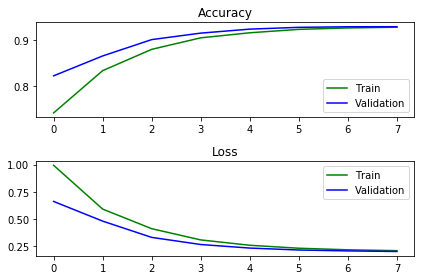

In [58]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_rnn_64.history["acc"], color="g", label="Train")
plt.plot(history_rnn_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_rnn_64.history["loss"], color="g", label="Train")
plt.plot(history_rnn_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 100

In [59]:
rnn_model = Sequential()
rnn_model.add(Embedding(DUTCH_S_MAX_FEATURES, 100, input_length=DUTCH_MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(DUTCH_T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 60, 100)           300200    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 60, 64)            10560     
_________________________________________________________________
dense_7 (Dense)              (None, 60, 17)            1105      
_________________________________________________________________
activation_7 (Activation)    (None, 60, 17)            0         
Total params: 311,865
Trainable params: 311,865
Non-trainable params: 0
_________________________________________________________________


In [60]:
history_rnn_100 = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn_100 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_rnn_100)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 48s 5ms/step - loss: 0.9566 - acc: 0.7500 - val_loss: 0.5827 - val_acc: 0.8494
Epoch 2/8
9815/9815 [==============================] - 30s 3ms/step - loss: 0.4946 - acc: 0.8609 - val_loss: 0.3807 - val_acc: 0.8895
Epoch 3/8
9815/9815 [==============================] - 23s 2ms/step - loss: 0.3349 - acc: 0.8994 - val_loss: 0.2776 - val_acc: 0.9133
Epoch 4/8
9815/9815 [==============================] - 23s 2ms/step - loss: 0.2643 - acc: 0.9154 - val_loss: 0.2360 - val_acc: 0.9224
Epoch 5/8
9815/9815 [==============================] - 24s 2ms/step - loss: 0.2334 - acc: 0.9227 - val_loss: 0.2177 - val_acc: 0.9261
Epoch 6/8
9815/9815 [==============================] - 23s 2ms/step - loss: 0.2177 - acc: 0.9261 - val_loss: 0.2086 - val_acc: 0.9278
Epoch 7/8
9815/9815 [==============================] - 25s 3ms/step - loss: 0.2094 - acc: 0.9275 - val_loss: 0.2030 - val_acc: 0.9287
Epoch 8/8
596/

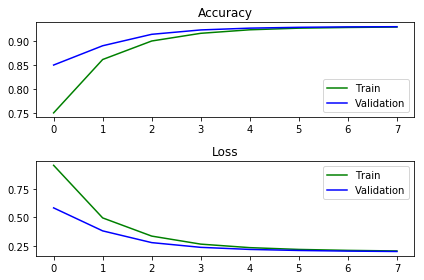

In [61]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_rnn_100.history["acc"], color="g", label="Train")
plt.plot(history_rnn_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_rnn_100.history["loss"], color="g", label="Train")
plt.plot(history_rnn_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embeggind 200

In [62]:
rnn_model = Sequential()
rnn_model.add(Embedding(DUTCH_S_MAX_FEATURES, 200, input_length=DUTCH_MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(DUTCH_T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 60, 200)           600400    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 60, 64)            16960     
_________________________________________________________________
dense_8 (Dense)              (None, 60, 17)            1105      
_________________________________________________________________
activation_8 (Activation)    (None, 60, 17)            0         
Total params: 618,465
Trainable params: 618,465
Non-trainable params: 0
_________________________________________________________________


In [63]:
history_rnn_200 = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn_200 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_rnn_200)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 56s 6ms/step - loss: 0.8108 - acc: 0.7855 - val_loss: 0.5118 - val_acc: 0.8654
Epoch 2/8
9815/9815 [==============================] - 37s 4ms/step - loss: 0.4166 - acc: 0.8808 - val_loss: 0.3182 - val_acc: 0.9057
Epoch 3/8
9815/9815 [==============================] - 38s 4ms/step - loss: 0.2903 - acc: 0.9093 - val_loss: 0.2517 - val_acc: 0.9174
Epoch 4/8
9815/9815 [==============================] - 42s 4ms/step - loss: 0.2432 - acc: 0.9194 - val_loss: 0.2234 - val_acc: 0.9250
Epoch 5/8
9815/9815 [==============================] - 33s 3ms/step - loss: 0.2213 - acc: 0.9253 - val_loss: 0.2097 - val_acc: 0.9281
Epoch 6/8
9815/9815 [==============================] - 34s 3ms/step - loss: 0.2095 - acc: 0.9275 - val_loss: 0.2030 - val_acc: 0.9292
Epoch 7/8
9815/9815 [==============================] - 34s 3ms/step - loss: 0.2024 - acc: 0.9292 - val_loss: 0.1988 - val_acc: 0.9300
Epoch 8/8
596/

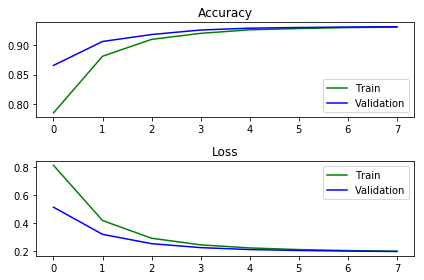

In [64]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_rnn_200.history["acc"], color="g", label="Train")
plt.plot(history_rnn_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_rnn_200.history["loss"], color="g", label="Train")
plt.plot(history_rnn_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Dutch LSTM

Embedding 64

In [65]:
lstm_model = Sequential()
lstm_model.add(Embedding(DUTCH_S_MAX_FEATURES, 64, input_length=DUTCH_MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(DUTCH_T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 60, 64)            192128    
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dense_9 (Dense)              (None, 60, 17)            1105      
_________________________________________________________________
activation_9 (Activation)    (None, 60, 17)            0         
Total params: 226,257
Trainable params: 226,257
Non-trainable params: 0
_________________________________________________________________


In [66]:
history_lstm_64 = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm_64 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_lstm_64)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 130s 13ms/step - loss: 0.9999 - acc: 0.7425 - val_loss: 0.6893 - val_acc: 0.7712
Epoch 2/8
9815/9815 [==============================] - 66s 7ms/step - loss: 0.6271 - acc: 0.8092 - val_loss: 0.5462 - val_acc: 0.8575
Epoch 3/8
9815/9815 [==============================] - 61s 6ms/step - loss: 0.4312 - acc: 0.8741 - val_loss: 0.3427 - val_acc: 0.8969
Epoch 4/8
9815/9815 [==============================] - 62s 6ms/step - loss: 0.3045 - acc: 0.9062 - val_loss: 0.2679 - val_acc: 0.9140
Epoch 5/8
9815/9815 [==============================] - 63s 6ms/step - loss: 0.2537 - acc: 0.9171 - val_loss: 0.2360 - val_acc: 0.9219
Epoch 6/8
9815/9815 [==============================] - 59s 6ms/step - loss: 0.2298 - acc: 0.9231 - val_loss: 0.2192 - val_acc: 0.9258
Epoch 7/8
9815/9815 [==============================] - 60s 6ms/step - loss: 0.2160 - acc: 0.9260 - val_loss: 0.2097 - val_acc: 0.9271
Epoch 8/8
59

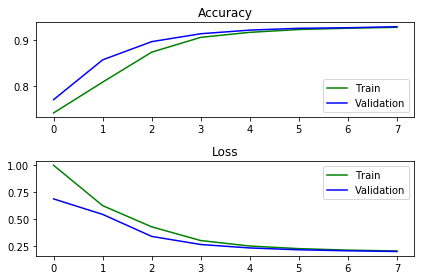

In [67]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_lstm_64.history["acc"], color="g", label="Train")
plt.plot(history_lstm_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_lstm_64.history["loss"], color="g", label="Train")
plt.plot(history_lstm_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embegging 100

In [68]:
lstm_model = Sequential()
lstm_model.add(Embedding(DUTCH_S_MAX_FEATURES, 100, input_length=DUTCH_MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(DUTCH_T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 60, 100)           300200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 64)            42240     
_________________________________________________________________
dense_10 (Dense)             (None, 60, 17)            1105      
_________________________________________________________________
activation_10 (Activation)   (None, 60, 17)            0         
Total params: 343,545
Trainable params: 343,545
Non-trainable params: 0
_________________________________________________________________


In [69]:
history_lstm_100 = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm_100 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_lstm_100)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 149s 15ms/step - loss: 0.9629 - acc: 0.7473 - val_loss: 0.6634 - val_acc: 0.7867
Epoch 2/8
9815/9815 [==============================] - 88s 9ms/step - loss: 0.5768 - acc: 0.8289 - val_loss: 0.4523 - val_acc: 0.8703
Epoch 3/8
9815/9815 [==============================] - 84s 9ms/step - loss: 0.3587 - acc: 0.8942 - val_loss: 0.2896 - val_acc: 0.9095
Epoch 4/8
9815/9815 [==============================] - 87s 9ms/step - loss: 0.2638 - acc: 0.9147 - val_loss: 0.2398 - val_acc: 0.9208
Epoch 5/8
9815/9815 [==============================] - 94s 10ms/step - loss: 0.2306 - acc: 0.9233 - val_loss: 0.2197 - val_acc: 0.9252
Epoch 6/8
9815/9815 [==============================] - 85s 9ms/step - loss: 0.2159 - acc: 0.9261 - val_loss: 0.2097 - val_acc: 0.9279
Epoch 7/8
9815/9815 [==============================] - 85s 9ms/step - loss: 0.2073 - acc: 0.9281 - val_loss: 0.2041 - val_acc: 0.9284
Epoch 8/8
5

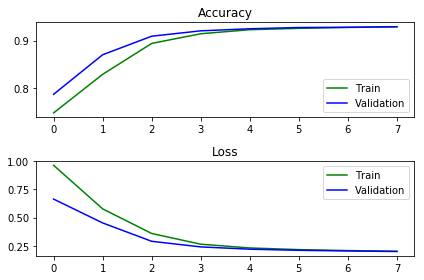

In [70]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_lstm_100.history["acc"], color="g", label="Train")
plt.plot(history_lstm_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_lstm_100.history["loss"], color="g", label="Train")
plt.plot(history_lstm_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 200

In [71]:
lstm_model = Sequential()
lstm_model.add(Embedding(DUTCH_S_MAX_FEATURES, 200, input_length=DUTCH_MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(DUTCH_T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 60, 200)           600400    
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 64)            67840     
_________________________________________________________________
dense_11 (Dense)             (None, 60, 17)            1105      
_________________________________________________________________
activation_11 (Activation)   (None, 60, 17)            0         
Total params: 669,345
Trainable params: 669,345
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_lstm_200 = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm_200 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_lstm_200)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 219s 22ms/step - loss: 0.8741 - acc: 0.7742 - val_loss: 0.5984 - val_acc: 0.8308
Epoch 2/8
9815/9815 [==============================] - 126s 13ms/step - loss: 0.4400 - acc: 0.8748 - val_loss: 0.3207 - val_acc: 0.9050
Epoch 3/8
9815/9815 [==============================] - 125s 13ms/step - loss: 0.2757 - acc: 0.9133 - val_loss: 0.2421 - val_acc: 0.9217
Epoch 4/8
9815/9815 [==============================] - 124s 13ms/step - loss: 0.2276 - acc: 0.9252 - val_loss: 0.2141 - val_acc: 0.9276
Epoch 5/8
9815/9815 [==============================] - 117s 12ms/step - loss: 0.2086 - acc: 0.9286 - val_loss: 0.2035 - val_acc: 0.9297
Epoch 6/8
9815/9815 [==============================] - 116s 12ms/step - loss: 0.1997 - acc: 0.9299 - val_loss: 0.1970 - val_acc: 0.9303
Epoch 7/8
9815/9815 [==============================] - 116s 12ms/step - loss: 0.1940 - acc: 0.9312 - val_loss: 0.1933 - val_acc: 0.9315


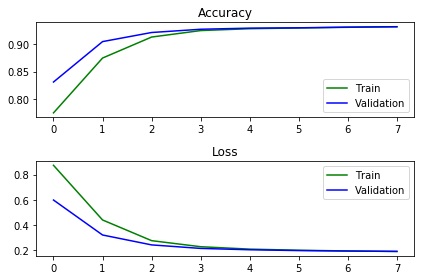

In [73]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_lstm_200.history["acc"], color="g", label="Train")
plt.plot(history_lstm_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_lstm_200.history["loss"], color="g", label="Train")
plt.plot(history_lstm_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Dutch GRU

Embedding 64

In [74]:
gru_model = Sequential()
gru_model.add(Embedding(DUTCH_S_MAX_FEATURES, 64, input_length=DUTCH_MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(DUTCH_T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 60, 64)            192128    
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 64)            24768     
_________________________________________________________________
dense_12 (Dense)             (None, 60, 17)            1105      
_________________________________________________________________
activation_12 (Activation)   (None, 60, 17)            0         
Total params: 218,001
Trainable params: 218,001
Non-trainable params: 0
_________________________________________________________________


In [75]:
history_gru_64 = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = gru_model.predict_classes(Xtest)
prediction_gru_64 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_gru_64)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 322s 33ms/step - loss: 0.9882 - acc: 0.7652 - val_loss: 0.6260 - val_acc: 0.8255
Epoch 2/8
9815/9815 [==============================] - 80s 8ms/step - loss: 0.4510 - acc: 0.8746 - val_loss: 0.3241 - val_acc: 0.9017
Epoch 3/8
9815/9815 [==============================] - 86s 9ms/step - loss: 0.2897 - acc: 0.9113 - val_loss: 0.2553 - val_acc: 0.9192
Epoch 4/8
9815/9815 [==============================] - 75s 8ms/step - loss: 0.2417 - acc: 0.9217 - val_loss: 0.2238 - val_acc: 0.9259
Epoch 5/8
9815/9815 [==============================] - 72s 7ms/step - loss: 0.2201 - acc: 0.9258 - val_loss: 0.2102 - val_acc: 0.9277
Epoch 6/8
9815/9815 [==============================] - 73s 7ms/step - loss: 0.2095 - acc: 0.9272 - val_loss: 0.2031 - val_acc: 0.9285
Epoch 7/8
9815/9815 [==============================] - 73s 7ms/step - loss: 0.2030 - acc: 0.9285 - val_loss: 0.1987 - val_acc: 0.9297
Epoch 8/8
59

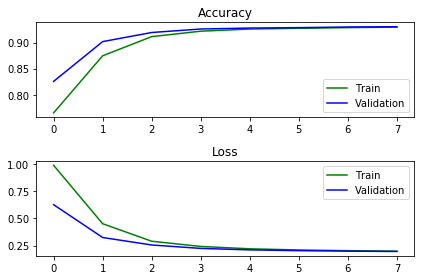

In [76]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_gru_64.history["acc"], color="g", label="Train")
plt.plot(history_gru_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_gru_64.history["loss"], color="g", label="Train")
plt.plot(history_gru_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 100

In [77]:
gru_model = Sequential()
gru_model.add(Embedding(DUTCH_S_MAX_FEATURES, 100, input_length=DUTCH_MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(DUTCH_T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 60, 100)           300200    
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 64)            31680     
_________________________________________________________________
dense_13 (Dense)             (None, 60, 17)            1105      
_________________________________________________________________
activation_13 (Activation)   (None, 60, 17)            0         
Total params: 332,985
Trainable params: 332,985
Non-trainable params: 0
_________________________________________________________________


In [78]:
history_gru_100 = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = gru_model.predict_classes(Xtest)
prediction_gru_100 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_gru_100)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 232s 24ms/step - loss: 0.9254 - acc: 0.8052 - val_loss: 0.5731 - val_acc: 0.8675
Epoch 2/8
9815/9815 [==============================] - 110s 11ms/step - loss: 0.3905 - acc: 0.8922 - val_loss: 0.2893 - val_acc: 0.9132
Epoch 3/8
9815/9815 [==============================] - 128s 13ms/step - loss: 0.2572 - acc: 0.9191 - val_loss: 0.2302 - val_acc: 0.9245
Epoch 4/8
9815/9815 [==============================] - 132s 13ms/step - loss: 0.2214 - acc: 0.9259 - val_loss: 0.2107 - val_acc: 0.9279
Epoch 5/8
9815/9815 [==============================] - 121s 12ms/step - loss: 0.2075 - acc: 0.9280 - val_loss: 0.2023 - val_acc: 0.9289
Epoch 6/8
9815/9815 [==============================] - 128s 13ms/step - loss: 0.2002 - acc: 0.9293 - val_loss: 0.1973 - val_acc: 0.9300
Epoch 7/8
9815/9815 [==============================] - 112s 11ms/step - loss: 0.1953 - acc: 0.9307 - val_loss: 0.1938 - val_acc: 0.9311


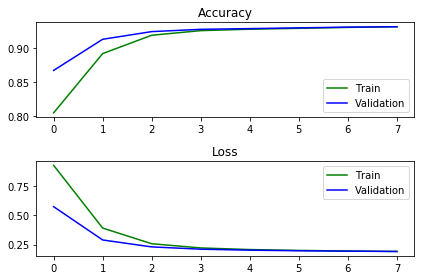

In [79]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_gru_100.history["acc"], color="g", label="Train")
plt.plot(history_gru_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_gru_100.history["loss"], color="g", label="Train")
plt.plot(history_gru_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 200

In [80]:
gru_model = Sequential()
gru_model.add(Embedding(DUTCH_S_MAX_FEATURES, 200, input_length=DUTCH_MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(DUTCH_T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 60, 200)           600400    
_________________________________________________________________
gru_3 (GRU)                  (None, 60, 64)            50880     
_________________________________________________________________
dense_14 (Dense)             (None, 60, 17)            1105      
_________________________________________________________________
activation_14 (Activation)   (None, 60, 17)            0         
Total params: 652,385
Trainable params: 652,385
Non-trainable params: 0
_________________________________________________________________


In [81]:
history_gru_200 = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = gru_model.predict_classes(Xtest)
prediction_gru_200 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_gru_200)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 401s 41ms/step - loss: 0.7927 - acc: 0.8329 - val_loss: 0.3791 - val_acc: 0.8992
Epoch 2/8
9815/9815 [==============================] - 194s 20ms/step - loss: 0.2896 - acc: 0.9139 - val_loss: 0.2393 - val_acc: 0.9226
Epoch 3/8
9815/9815 [==============================] - 170s 17ms/step - loss: 0.2223 - acc: 0.9258 - val_loss: 0.2106 - val_acc: 0.9284
Epoch 4/8
9815/9815 [==============================] - 175s 18ms/step - loss: 0.2045 - acc: 0.9289 - val_loss: 0.2007 - val_acc: 0.9295
Epoch 5/8
9815/9815 [==============================] - 1389s 142ms/step - loss: 0.1960 - acc: 0.9307 - val_loss: 0.1949 - val_acc: 0.9305
Epoch 6/8
9815/9815 [==============================] - 154s 16ms/step - loss: 0.1909 - acc: 0.9321 - val_loss: 0.1915 - val_acc: 0.9319
Epoch 7/8
9815/9815 [==============================] - 155s 16ms/step - loss: 0.1872 - acc: 0.9331 - val_loss: 0.1883 - val_acc: 0.932

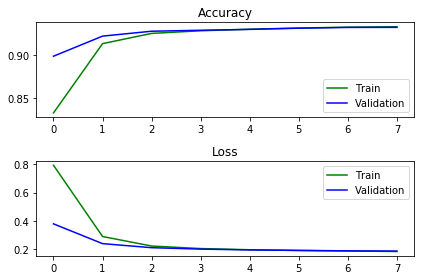

In [82]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_gru_200.history["acc"], color="g", label="Train")
plt.plot(history_gru_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_gru_200.history["loss"], color="g", label="Train")
plt.plot(history_gru_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Dutch Biderictorial LSTM

Embedding 64

In [83]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(DUTCH_S_MAX_FEATURES, 64, input_length=DUTCH_MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(DUTCH_T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 60, 64)            192128    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 128)           66048     
_________________________________________________________________
dense_15 (Dense)             (None, 60, 17)            2193      
_________________________________________________________________
activation_15 (Activation)   (None, 60, 17)            0         
Total params: 260,369
Trainable params: 260,369
Non-trainable params: 0
_________________________________________________________________


In [84]:
history_bilstm_64 = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm_64 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_bilstm_64)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 676s 69ms/step - loss: 0.9070 - acc: 0.7600 - val_loss: 0.6059 - val_acc: 0.7937
Epoch 2/8
9815/9815 [==============================] - 375s 38ms/step - loss: 0.5412 - acc: 0.8325 - val_loss: 0.4216 - val_acc: 0.8810
Epoch 3/8
9815/9815 [==============================] - 373s 38ms/step - loss: 0.3310 - acc: 0.8965 - val_loss: 0.2716 - val_acc: 0.9114
Epoch 4/8
9815/9815 [==============================] - 410s 42ms/step - loss: 0.2453 - acc: 0.9184 - val_loss: 0.2192 - val_acc: 0.9267
Epoch 5/8
9815/9815 [==============================] - 413s 42ms/step - loss: 0.2082 - acc: 0.9302 - val_loss: 0.1946 - val_acc: 0.9348
Epoch 6/8
9815/9815 [==============================] - 434s 44ms/step - loss: 0.1904 - acc: 0.9357 - val_loss: 0.1825 - val_acc: 0.9381
Epoch 7/8
9815/9815 [==============================] - 424s 43ms/step - loss: 0.1806 - acc: 0.9383 - val_loss: 0.1754 - val_acc: 0.9403


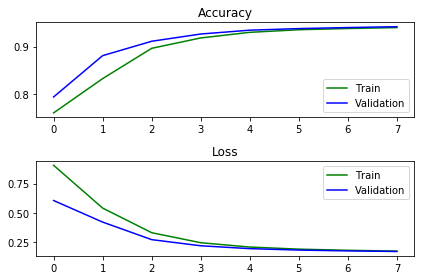

In [85]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_bilstm_64.history["acc"], color="g", label="Train")
plt.plot(history_bilstm_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_bilstm_64.history["loss"], color="g", label="Train")
plt.plot(history_bilstm_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 100

In [42]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(DUTCH_S_MAX_FEATURES, 100, input_length=DUTCH_MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(DUTCH_T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 60, 100)           300200    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 128)           84480     
_________________________________________________________________
dense_8 (Dense)              (None, 60, 17)            2193      
_________________________________________________________________
activation_8 (Activation)    (None, 60, 17)            0         
Total params: 386,873
Trainable params: 386,873
Non-trainable params: 0
_________________________________________________________________


In [43]:
history_bilstm_100 = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm_100 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_bilstm_100)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 299s 30ms/step - loss: 0.8420 - acc: 0.7751 - val_loss: 0.5774 - val_acc: 0.8201
Epoch 2/8
9815/9815 [==============================] - 201s 21ms/step - loss: 0.4421 - acc: 0.8712 - val_loss: 0.3074 - val_acc: 0.9060
Epoch 3/8
9815/9815 [==============================] - 219s 22ms/step - loss: 0.2597 - acc: 0.9159 - val_loss: 0.2212 - val_acc: 0.9257
Epoch 4/8
9815/9815 [==============================] - 213s 22ms/step - loss: 0.2053 - acc: 0.9306 - val_loss: 0.1895 - val_acc: 0.9366
Epoch 5/8
9815/9815 [==============================] - 196s 20ms/step - loss: 0.1827 - acc: 0.9380 - val_loss: 0.1755 - val_acc: 0.9406
Epoch 6/8
9815/9815 [==============================] - 179s 18ms/step - loss: 0.1724 - acc: 0.9408 - val_loss: 0.1689 - val_acc: 0.9420
Epoch 7/8
9815/9815 [==============================] - 173s 18ms/step - loss: 0.1654 - acc: 0.9429 - val_loss: 0.1632 - val_acc: 0.9440


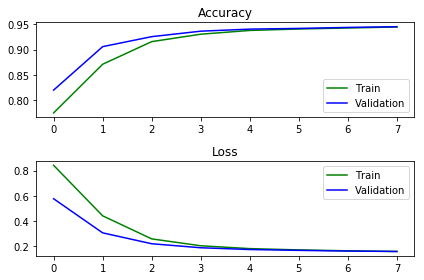

In [44]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_bilstm_100.history["acc"], color="g", label="Train")
plt.plot(history_bilstm_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_bilstm_100.history["loss"], color="g", label="Train")
plt.plot(history_bilstm_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 200

In [45]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(DUTCH_S_MAX_FEATURES, 200, input_length=DUTCH_MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(DUTCH_MAX_SEQLEN, DUTCH_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(DUTCH_T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 60, 200)           600400    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 128)           135680    
_________________________________________________________________
dense_9 (Dense)              (None, 60, 17)            2193      
_________________________________________________________________
activation_9 (Activation)    (None, 60, 17)            0         
Total params: 738,273
Trainable params: 738,273
Non-trainable params: 0
_________________________________________________________________


In [46]:
history_bilstm_200 = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=DUTCH_T_MAX_FEATURES)])
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=DUTCH_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm_200 = evaluate(Ytest, prediction, dt_test_tags)
print(prediction_bilstm_200)

Train on 9815 samples, validate on 2454 samples
Epoch 1/8
9815/9815 [==============================] - 506s 52ms/step - loss: 0.7694 - acc: 0.7956 - val_loss: 0.4522 - val_acc: 0.8729
Epoch 2/8
9815/9815 [==============================] - 285s 29ms/step - loss: 0.3137 - acc: 0.9042 - val_loss: 0.2387 - val_acc: 0.9210
Epoch 3/8
9815/9815 [==============================] - 315s 32ms/step - loss: 0.2116 - acc: 0.9285 - val_loss: 0.1904 - val_acc: 0.9354
Epoch 4/8
9815/9815 [==============================] - 297s 30ms/step - loss: 0.1813 - acc: 0.9381 - val_loss: 0.1735 - val_acc: 0.9408
Epoch 5/8
9815/9815 [==============================] - 294s 30ms/step - loss: 0.1686 - acc: 0.9418 - val_loss: 0.1650 - val_acc: 0.9436
Epoch 6/8
9815/9815 [==============================] - 258s 26ms/step - loss: 0.1609 - acc: 0.9441 - val_loss: 0.1597 - val_acc: 0.9452
Epoch 7/8
9815/9815 [==============================] - 251s 26ms/step - loss: 0.1552 - acc: 0.9460 - val_loss: 0.1558 - val_acc: 0.9463


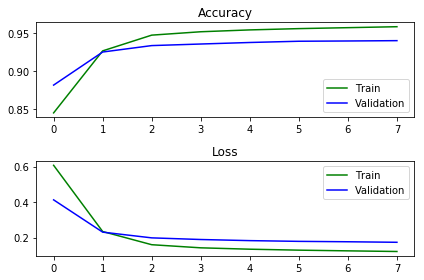

In [84]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_bilstm_200.history["acc"], color="g", label="Train")
plt.plot(history_bilstm_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_bilstm_200.history["loss"], color="g", label="Train")
plt.plot(history_bilstm_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# Словацкий язык

Изначально полученный размер MAX_SEQLEN также совсем немного урезали

In [19]:
SLOVAK_MAX_SEQLEN = 50
SLOVAK_S_MAX_FEATURES = 4000
SLOVAK_T_MAX_FEATURES = 16  

In [20]:
sl_word2index = {w[0]: i + 2 for i,w in enumerate(SLOVAK_TRAIN.word_freqs.most_common(SLOVAK_S_MAX_FEATURES))}
sl_word2index['PAD'] = 0
sl_word2index['UNK'] = 1
sl_tag2index = {t: i + 1 for i,t in enumerate(SLOVAK_TRAIN.tag_freqs)}
sl_tag2index['PAD'] = 0
sl_tag2index['UNK'] = 1

In [21]:
SLOVAK_S_MAX_FEATURES += 2
SLOVAK_T_MAX_FEATURES += 2

In [22]:
sl_train_sents, sl_train_tags = get_all_sents('Data\\Input\\Slovak\\UD_Slovak-SNK\\sk_snk-ud-train.conllu')
sl_test_sents, sl_test_tags = get_all_sents('Data\\Input\\Slovak\\UD_Slovak-SNK\\sk_snk-ud-test.conllu')

In [23]:
X1 = build_tensor(sl_train_sents, len(sl_train_sents), sl_word2index, SLOVAK_MAX_SEQLEN)
Xtest1 = build_tensor(sl_test_sents, len(sl_test_sents), sl_word2index, SLOVAK_MAX_SEQLEN)
Y1 = build_tensor(sl_train_tags, len(sl_train_sents), sl_tag2index, SLOVAK_MAX_SEQLEN)
Ytest1 = build_tensor(sl_test_tags, len(sl_test_sents), sl_tag2index, SLOVAK_MAX_SEQLEN)
Xtrain1, Xval1, Ytrain1, Yval1 = train_test_split(X1, Y1, test_size = 0.2, random_state=42)

### Slovak SimpleRNN

Embedding 64

In [95]:
rnn_model1 = Sequential()
rnn_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 64, input_length=SLOVAK_MAX_SEQLEN))
rnn_model1.add(SimpleRNN(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
rnn_model1.add(Activation("softmax"))

rnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 64)            256256    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 50, 64)            8256      
_________________________________________________________________
dense_16 (Dense)             (None, 50, 19)            1235      
_________________________________________________________________
activation_16 (Activation)   (None, 50, 19)            0         
Total params: 265,747
Trainable params: 265,747
Non-trainable params: 0
_________________________________________________________________


In [96]:
history1_rnn_64 = rnn_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = rnn_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model1.predict_classes(Xtest1)
prediction1_rnn_64 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_rnn_64)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 376s 55ms/step - loss: 1.0054 - acc: 0.7623 - val_loss: 0.6142 - val_acc: 0.8229
Epoch 2/8
6786/6786 [==============================] - 57s 8ms/step - loss: 0.5776 - acc: 0.8343 - val_loss: 0.4910 - val_acc: 0.8576
Epoch 3/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.4840 - acc: 0.8547 - val_loss: 0.4425 - val_acc: 0.8644
Epoch 4/8
6786/6786 [==============================] - 57s 8ms/step - loss: 0.4324 - acc: 0.8682 - val_loss: 0.3959 - val_acc: 0.8810
Epoch 5/8
6786/6786 [==============================] - 55s 8ms/step - loss: 0.3840 - acc: 0.8827 - val_loss: 0.3522 - val_acc: 0.8913
Epoch 6/8
6786/6786 [==============================] - 64s 9ms/step - loss: 0.3469 - acc: 0.8914 - val_loss: 0.3226 - val_acc: 0.9002
Epoch 7/8
6786/6786 [==============================] - 55s 8ms/step - loss: 0.3205 - acc: 0.8997 - val_loss: 0.3009 - val_acc: 0.9069
Epoch 8/8
10

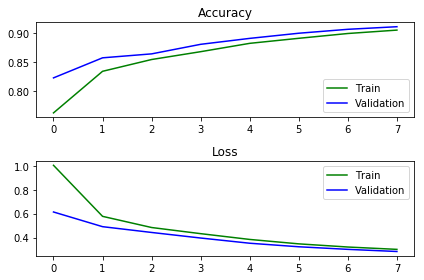

In [97]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_rnn_64.history["acc"], color="g", label="Train")
plt.plot(history1_rnn_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_rnn_64.history["loss"], color="g", label="Train")
plt.plot(history1_rnn_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 100

In [98]:
rnn_model1 = Sequential()
rnn_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 100, input_length=SLOVAK_MAX_SEQLEN))
rnn_model1.add(SimpleRNN(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
rnn_model1.add(Activation("softmax"))

rnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 100)           400400    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 50, 64)            10560     
_________________________________________________________________
dense_17 (Dense)             (None, 50, 19)            1235      
_________________________________________________________________
activation_17 (Activation)   (None, 50, 19)            0         
Total params: 412,195
Trainable params: 412,195
Non-trainable params: 0
_________________________________________________________________


In [99]:
history1_rnn_100 = rnn_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = rnn_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model1.predict_classes(Xtest1)
prediction1_rnn_100 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_rnn_100)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 315s 46ms/step - loss: 0.9293 - acc: 0.7767 - val_loss: 0.5682 - val_acc: 0.8287
Epoch 2/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.5216 - acc: 0.8464 - val_loss: 0.4591 - val_acc: 0.8637
Epoch 3/8
6786/6786 [==============================] - 55s 8ms/step - loss: 0.4453 - acc: 0.8665 - val_loss: 0.4084 - val_acc: 0.8782
Epoch 4/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.3887 - acc: 0.8830 - val_loss: 0.3525 - val_acc: 0.8931
Epoch 5/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.3380 - acc: 0.8969 - val_loss: 0.3100 - val_acc: 0.9066
Epoch 6/8
6786/6786 [==============================] - 57s 8ms/step - loss: 0.3038 - acc: 0.9075 - val_loss: 0.2819 - val_acc: 0.9146
Epoch 7/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.2790 - acc: 0.9140 - val_loss: 0.2616 - val_acc: 0.9195
Epoch 8/8
10

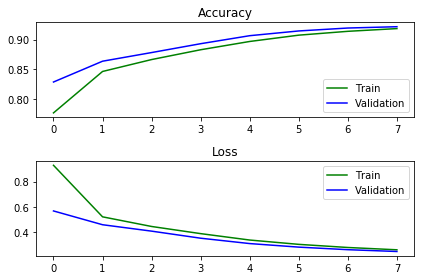

In [100]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_rnn_100.history["acc"], color="g", label="Train")
plt.plot(history1_rnn_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_rnn_100.history["loss"], color="g", label="Train")
plt.plot(history1_rnn_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 200

In [101]:
rnn_model1 = Sequential()
rnn_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 200, input_length=SLOVAK_MAX_SEQLEN))
rnn_model1.add(SimpleRNN(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
rnn_model1.add(Activation("softmax"))

rnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 50, 200)           800800    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 50, 64)            16960     
_________________________________________________________________
dense_18 (Dense)             (None, 50, 19)            1235      
_________________________________________________________________
activation_18 (Activation)   (None, 50, 19)            0         
Total params: 818,995
Trainable params: 818,995
Non-trainable params: 0
_________________________________________________________________


In [102]:
history1_rnn_200 = rnn_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = rnn_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model1.predict_classes(Xtest1)
prediction1_rnn_200 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_rnn_200)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 410s 60ms/step - loss: 0.8372 - acc: 0.7981 - val_loss: 0.4806 - val_acc: 0.8610
Epoch 2/8
6786/6786 [==============================] - 52s 8ms/step - loss: 0.4493 - acc: 0.8694 - val_loss: 0.3926 - val_acc: 0.8891
Epoch 3/8
6786/6786 [==============================] - 54s 8ms/step - loss: 0.3651 - acc: 0.8945 - val_loss: 0.3224 - val_acc: 0.9061
Epoch 4/8
6786/6786 [==============================] - 51s 8ms/step - loss: 0.3091 - acc: 0.9077 - val_loss: 0.2818 - val_acc: 0.9146
Epoch 5/8
6786/6786 [==============================] - 55s 8ms/step - loss: 0.2750 - acc: 0.9159 - val_loss: 0.2562 - val_acc: 0.9201
Epoch 6/8
6786/6786 [==============================] - 62s 9ms/step - loss: 0.2527 - acc: 0.9201 - val_loss: 0.2410 - val_acc: 0.9217
Epoch 7/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.2389 - acc: 0.9224 - val_loss: 0.2325 - val_acc: 0.9235
Epoch 8/8
10

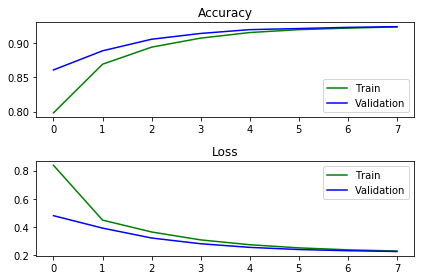

In [103]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_rnn_200.history["acc"], color="g", label="Train")
plt.plot(history1_rnn_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_rnn_200.history["loss"], color="g", label="Train")
plt.plot(history1_rnn_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Slovak LSTM

Embedding 64

In [104]:
lstm_model1 = Sequential()
lstm_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 64, input_length=SLOVAK_MAX_SEQLEN))
lstm_model1.add(LSTM(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
lstm_model1.add(Activation("softmax"))

lstm_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 50, 64)            256256    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 64)            33024     
_________________________________________________________________
dense_19 (Dense)             (None, 50, 19)            1235      
_________________________________________________________________
activation_19 (Activation)   (None, 50, 19)            0         
Total params: 290,515
Trainable params: 290,515
Non-trainable params: 0
_________________________________________________________________


In [105]:
history1_lstm_64 = lstm_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = lstm_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = lstm_model1.predict_classes(Xtest1)
prediction1_lstm_64 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_lstm_64)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 477s 70ms/step - loss: 1.0088 - acc: 0.7918 - val_loss: 0.5945 - val_acc: 0.8198
Epoch 2/8
6786/6786 [==============================] - 144s 21ms/step - loss: 0.5351 - acc: 0.8348 - val_loss: 0.4900 - val_acc: 0.8466
Epoch 3/8
6786/6786 [==============================] - 140s 21ms/step - loss: 0.4678 - acc: 0.8482 - val_loss: 0.4453 - val_acc: 0.8523
Epoch 4/8
6786/6786 [==============================] - 148s 22ms/step - loss: 0.4276 - acc: 0.8546 - val_loss: 0.4040 - val_acc: 0.8687
Epoch 5/8
6786/6786 [==============================] - 148s 22ms/step - loss: 0.3835 - acc: 0.8798 - val_loss: 0.3574 - val_acc: 0.8902
Epoch 6/8
6786/6786 [==============================] - 148s 22ms/step - loss: 0.3379 - acc: 0.8955 - val_loss: 0.3134 - val_acc: 0.9022
Epoch 7/8
6786/6786 [==============================] - 157s 23ms/step - loss: 0.3026 - acc: 0.9058 - val_loss: 0.2866 - val_acc: 0.9100


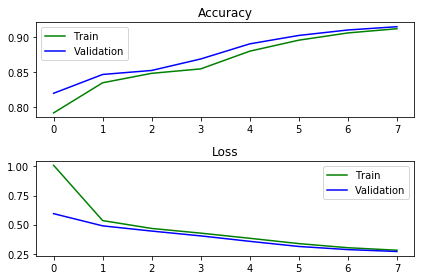

In [106]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_lstm_64.history["acc"], color="g", label="Train")
plt.plot(history1_lstm_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_lstm_64.history["loss"], color="g", label="Train")
plt.plot(history1_lstm_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 100

In [107]:
lstm_model1 = Sequential()
lstm_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 100, input_length=SLOVAK_MAX_SEQLEN))
lstm_model1.add(LSTM(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
lstm_model1.add(Activation("softmax"))

lstm_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 50, 100)           400400    
_________________________________________________________________
lstm_9 (LSTM)                (None, 50, 64)            42240     
_________________________________________________________________
dense_20 (Dense)             (None, 50, 19)            1235      
_________________________________________________________________
activation_20 (Activation)   (None, 50, 19)            0         
Total params: 443,875
Trainable params: 443,875
Non-trainable params: 0
_________________________________________________________________


In [108]:
history1_lstm_100 = lstm_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = lstm_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = lstm_model1.predict_classes(Xtest1)
prediction1_lstm_100 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_lstm_100)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 532s 78ms/step - loss: 0.9610 - acc: 0.8008 - val_loss: 0.5571 - val_acc: 0.8230
Epoch 2/8
6786/6786 [==============================] - 161s 24ms/step - loss: 0.5066 - acc: 0.8423 - val_loss: 0.4659 - val_acc: 0.8532
Epoch 3/8
6786/6786 [==============================] - 144s 21ms/step - loss: 0.4407 - acc: 0.8555 - val_loss: 0.4128 - val_acc: 0.8645
Epoch 4/8
6786/6786 [==============================] - 154s 23ms/step - loss: 0.3852 - acc: 0.8822 - val_loss: 0.3515 - val_acc: 0.8964
Epoch 5/8
6786/6786 [==============================] - 154s 23ms/step - loss: 0.3301 - acc: 0.9016 - val_loss: 0.3081 - val_acc: 0.9089
Epoch 6/8
6786/6786 [==============================] - 173s 26ms/step - loss: 0.2971 - acc: 0.9106 - val_loss: 0.2832 - val_acc: 0.9146
Epoch 7/8
6786/6786 [==============================] - 178s 26ms/step - loss: 0.2756 - acc: 0.9163 - val_loss: 0.2653 - val_acc: 0.9190


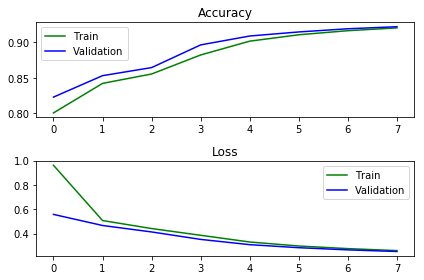

In [109]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_lstm_100.history["acc"], color="g", label="Train")
plt.plot(history1_lstm_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_lstm_100.history["loss"], color="g", label="Train")
plt.plot(history1_lstm_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 200

In [110]:
lstm_model1 = Sequential()
lstm_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 200, input_length=SLOVAK_MAX_SEQLEN))
lstm_model1.add(LSTM(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
lstm_model1.add(Activation("softmax"))

lstm_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 50, 200)           800800    
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 64)            67840     
_________________________________________________________________
dense_21 (Dense)             (None, 50, 19)            1235      
_________________________________________________________________
activation_21 (Activation)   (None, 50, 19)            0         
Total params: 869,875
Trainable params: 869,875
Non-trainable params: 0
_________________________________________________________________


In [111]:
history1_lstm_200 = lstm_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = lstm_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = lstm_model1.predict_classes(Xtest1)
prediction1_lstm_200 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_lstm_200)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 769s 113ms/step - loss: 0.8491 - acc: 0.8165 - val_loss: 0.4992 - val_acc: 0.8474
Epoch 2/8
6786/6786 [==============================] - 201s 30ms/step - loss: 0.4568 - acc: 0.8523 - val_loss: 0.4146 - val_acc: 0.8691
Epoch 3/8
6786/6786 [==============================] - 195s 29ms/step - loss: 0.3775 - acc: 0.8859 - val_loss: 0.3366 - val_acc: 0.8975
Epoch 4/8
6786/6786 [==============================] - 195s 29ms/step - loss: 0.3147 - acc: 0.9046 - val_loss: 0.2924 - val_acc: 0.9111
Epoch 5/8
6786/6786 [==============================] - 194s 29ms/step - loss: 0.2804 - acc: 0.9141 - val_loss: 0.2661 - val_acc: 0.9177
Epoch 6/8
6786/6786 [==============================] - 197s 29ms/step - loss: 0.2580 - acc: 0.9195 - val_loss: 0.2491 - val_acc: 0.9218
Epoch 7/8
6786/6786 [==============================] - 224s 33ms/step - loss: 0.2436 - acc: 0.9223 - val_loss: 0.2386 - val_acc: 0.9235

In [ ]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_lstm_200.history["acc"], color="g", label="Train")
plt.plot(history1_lstm_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_lstm_200.history["loss"], color="g", label="Train")
plt.plot(history1_lstm_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Slovak GRU

Embedding 64

In [24]:
gru_model1 = Sequential()
gru_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 64, input_length=SLOVAK_MAX_SEQLEN))
gru_model1.add(GRU(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
gru_model1.add(Activation("softmax"))

gru_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            256128    
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 64)            24768     
_________________________________________________________________
dense_2 (Dense)              (None, 50, 18)            1170      
_________________________________________________________________
activation_2 (Activation)    (None, 50, 18)            0         
Total params: 282,066
Trainable params: 282,066
Non-trainable params: 0
_________________________________________________________________


In [25]:
history1_gru_64 = gru_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = gru_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = gru_model1.predict_classes(Xtest1)
prediction1_gru_64 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_gru_64)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 31s 5ms/step - loss: 1.0058 - acc: 0.8003 - val_loss: 0.5330 - val_acc: 0.8244
Epoch 2/8
6786/6786 [==============================] - 8s 1ms/step - loss: 0.4747 - acc: 0.8466 - val_loss: 0.4193 - val_acc: 0.8656
Epoch 3/8
6786/6786 [==============================] - 9s 1ms/step - loss: 0.3809 - acc: 0.8809 - val_loss: 0.3413 - val_acc: 0.8961
Epoch 4/8
6786/6786 [==============================] - 9s 1ms/step - loss: 0.3201 - acc: 0.9014 - val_loss: 0.2971 - val_acc: 0.9091
Epoch 5/8
6786/6786 [==============================] - 9s 1ms/step - loss: 0.2871 - acc: 0.9114 - val_loss: 0.2711 - val_acc: 0.9169
Epoch 6/8
6786/6786 [==============================] - 9s 1ms/step - loss: 0.2654 - acc: 0.9177 - val_loss: 0.2531 - val_acc: 0.9200
Epoch 7/8
6786/6786 [==============================] - 10s 2ms/step - loss: 0.2491 - acc: 0.9207 - val_loss: 0.2411 - val_acc: 0.9233
Epoch 8/8
1061/1061

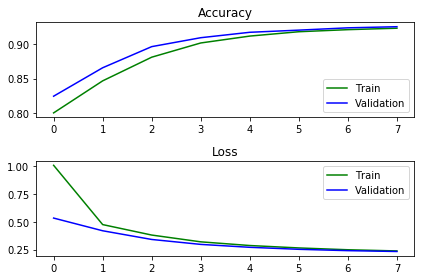

In [26]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_gru_64.history["acc"], color="g", label="Train")
plt.plot(history1_gru_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_gru_64.history["loss"], color="g", label="Train")
plt.plot(history1_gru_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 100

In [27]:
gru_model1 = Sequential()
gru_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 100, input_length=SLOVAK_MAX_SEQLEN))
gru_model1.add(GRU(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
gru_model1.add(Activation("softmax"))

gru_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           400200    
_________________________________________________________________
gru_3 (GRU)                  (None, 50, 64)            31680     
_________________________________________________________________
dense_3 (Dense)              (None, 50, 18)            1170      
_________________________________________________________________
activation_3 (Activation)    (None, 50, 18)            0         
Total params: 433,050
Trainable params: 433,050
Non-trainable params: 0
_________________________________________________________________


In [28]:
history1_gru_100 = gru_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = gru_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = gru_model1.predict_classes(Xtest1)
prediction1_gru_100 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_gru_100)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 37s 5ms/step - loss: 0.9464 - acc: 0.8110 - val_loss: 0.4857 - val_acc: 0.8490
Epoch 2/8
6786/6786 [==============================] - 21s 3ms/step - loss: 0.4392 - acc: 0.8624 - val_loss: 0.3895 - val_acc: 0.8841
Epoch 3/8
6786/6786 [==============================] - 21s 3ms/step - loss: 0.3491 - acc: 0.8990 - val_loss: 0.3131 - val_acc: 0.9099
Epoch 4/8
6786/6786 [==============================] - 18s 3ms/step - loss: 0.2949 - acc: 0.9126 - val_loss: 0.2754 - val_acc: 0.9162
Epoch 5/8
6786/6786 [==============================] - 13s 2ms/step - loss: 0.2652 - acc: 0.9178 - val_loss: 0.2526 - val_acc: 0.9202
Epoch 6/8
6786/6786 [==============================] - 13s 2ms/step - loss: 0.2461 - acc: 0.9214 - val_loss: 0.2383 - val_acc: 0.9226
Epoch 7/8
6786/6786 [==============================] - 15s 2ms/step - loss: 0.2339 - acc: 0.9238 - val_loss: 0.2293 - val_acc: 0.9254
Epoch 8/8
1061

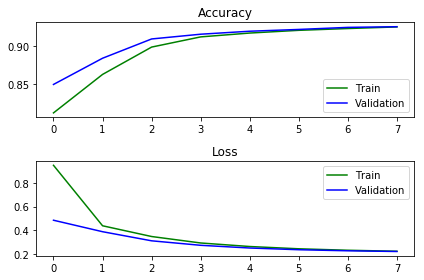

In [29]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_gru_100.history["acc"], color="g", label="Train")
plt.plot(history1_gru_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_gru_100.history["loss"], color="g", label="Train")
plt.plot(history1_gru_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 200

In [30]:
gru_model1 = Sequential()
gru_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 200, input_length=SLOVAK_MAX_SEQLEN))
gru_model1.add(GRU(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
gru_model1.add(Activation("softmax"))

gru_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 200)           800400    
_________________________________________________________________
gru_4 (GRU)                  (None, 50, 64)            50880     
_________________________________________________________________
dense_4 (Dense)              (None, 50, 18)            1170      
_________________________________________________________________
activation_4 (Activation)    (None, 50, 18)            0         
Total params: 852,450
Trainable params: 852,450
Non-trainable params: 0
_________________________________________________________________


In [31]:
history1_gru_200 = gru_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = gru_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = gru_model1.predict_classes(Xtest1)
prediction1_gru_200 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_gru_200)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 50s 7ms/step - loss: 0.7845 - acc: 0.8326 - val_loss: 0.4329 - val_acc: 0.8636
Epoch 2/8
6786/6786 [==============================] - 24s 4ms/step - loss: 0.3695 - acc: 0.8931 - val_loss: 0.3152 - val_acc: 0.9087
Epoch 3/8
6786/6786 [==============================] - 22s 3ms/step - loss: 0.2920 - acc: 0.9137 - val_loss: 0.2696 - val_acc: 0.9180
Epoch 4/8
6786/6786 [==============================] - 26s 4ms/step - loss: 0.2582 - acc: 0.9197 - val_loss: 0.2465 - val_acc: 0.9214
Epoch 5/8
6786/6786 [==============================] - 22s 3ms/step - loss: 0.2396 - acc: 0.9229 - val_loss: 0.2336 - val_acc: 0.9234
Epoch 6/8
6786/6786 [==============================] - 24s 4ms/step - loss: 0.2288 - acc: 0.9254 - val_loss: 0.2262 - val_acc: 0.9259
Epoch 7/8
6786/6786 [==============================] - 25s 4ms/step - loss: 0.2210 - acc: 0.9274 - val_loss: 0.2211 - val_acc: 0.9270
Epoch 8/8
1061

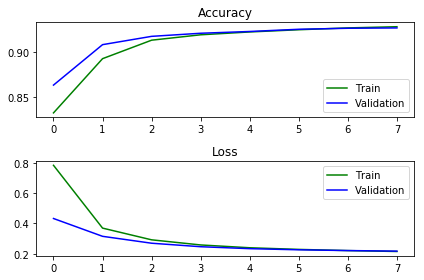

In [32]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_gru_200.history["acc"], color="g", label="Train")
plt.plot(history1_gru_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_gru_200.history["loss"], color="g", label="Train")
plt.plot(history1_gru_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Slovak Biderictorial LSTM

Embedding 64

In [33]:
bilstm_model1 = Sequential()
bilstm_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 64, input_length=SLOVAK_MAX_SEQLEN))
bilstm_model1.add(Bidirectional(LSTM(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
bilstm_model1.add(Activation("softmax"))

bilstm_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 64)            256128    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           66048     
_________________________________________________________________
dense_5 (Dense)              (None, 50, 18)            2322      
_________________________________________________________________
activation_5 (Activation)    (None, 50, 18)            0         
Total params: 324,498
Trainable params: 324,498
Non-trainable params: 0
_________________________________________________________________


In [34]:
history1_bilstm_64 = bilstm_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = bilstm_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = bilstm_model1.predict_classes(Xtest1)
prediction1_bilstm_64 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_bilstm_64)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 95s 14ms/step - loss: 0.8606 - acc: 0.8123 - val_loss: 0.4935 - val_acc: 0.8351
Epoch 2/8
6786/6786 [==============================] - 37s 6ms/step - loss: 0.4537 - acc: 0.8503 - val_loss: 0.4169 - val_acc: 0.8559
Epoch 3/8
6786/6786 [==============================] - 40s 6ms/step - loss: 0.3875 - acc: 0.8694 - val_loss: 0.3490 - val_acc: 0.8860
Epoch 4/8
6786/6786 [==============================] - 34s 5ms/step - loss: 0.3245 - acc: 0.8957 - val_loss: 0.2957 - val_acc: 0.9023
Epoch 5/8
6786/6786 [==============================] - 40s 6ms/step - loss: 0.2787 - acc: 0.9109 - val_loss: 0.2587 - val_acc: 0.9182
Epoch 6/8
6786/6786 [==============================] - 41s 6ms/step - loss: 0.2490 - acc: 0.9219 - val_loss: 0.2350 - val_acc: 0.9256
Epoch 7/8
6786/6786 [==============================] - 55s 8ms/step - loss: 0.2292 - acc: 0.9276 - val_loss: 0.2194 - val_acc: 0.9305
Epoch 8/8
106

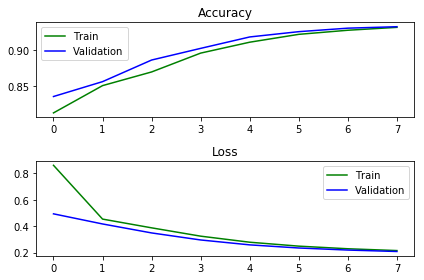

In [35]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_bilstm_64.history["acc"], color="g", label="Train")
plt.plot(history1_bilstm_64.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_bilstm_64.history["loss"], color="g", label="Train")
plt.plot(history1_bilstm_64.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 100

In [36]:
bilstm_model1 = Sequential()
bilstm_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 100, input_length=SLOVAK_MAX_SEQLEN))
bilstm_model1.add(Bidirectional(LSTM(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
bilstm_model1.add(Activation("softmax"))

bilstm_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           400200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
dense_6 (Dense)              (None, 50, 18)            2322      
_________________________________________________________________
activation_6 (Activation)    (None, 50, 18)            0         
Total params: 487,002
Trainable params: 487,002
Non-trainable params: 0
_________________________________________________________________


In [37]:
history1_bilstm_100 = bilstm_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = bilstm_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = bilstm_model1.predict_classes(Xtest1)
prediction1_bilstm_100 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_bilstm_100)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 137s 20ms/step - loss: 0.8237 - acc: 0.8138 - val_loss: 0.4697 - val_acc: 0.8523
Epoch 2/8
6786/6786 [==============================] - 54s 8ms/step - loss: 0.4394 - acc: 0.8554 - val_loss: 0.4090 - val_acc: 0.8566
Epoch 3/8
6786/6786 [==============================] - 55s 8ms/step - loss: 0.3774 - acc: 0.8779 - val_loss: 0.3337 - val_acc: 0.8994
Epoch 4/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.3005 - acc: 0.9073 - val_loss: 0.2669 - val_acc: 0.9167
Epoch 5/8
6786/6786 [==============================] - 61s 9ms/step - loss: 0.2516 - acc: 0.9224 - val_loss: 0.2348 - val_acc: 0.9266
Epoch 6/8
6786/6786 [==============================] - 58s 9ms/step - loss: 0.2256 - acc: 0.9301 - val_loss: 0.2150 - val_acc: 0.9324
Epoch 7/8
6786/6786 [==============================] - 56s 8ms/step - loss: 0.2096 - acc: 0.9338 - val_loss: 0.2039 - val_acc: 0.9347
Epoch 8/8
10

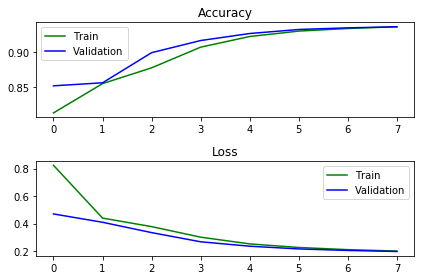

In [38]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_bilstm_100.history["acc"], color="g", label="Train")
plt.plot(history1_bilstm_100.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_bilstm_100.history["loss"], color="g", label="Train")
plt.plot(history1_bilstm_100.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Embedding 200

In [39]:
bilstm_model1 = Sequential()
bilstm_model1.add(Embedding(SLOVAK_S_MAX_FEATURES, 200, input_length=SLOVAK_MAX_SEQLEN))
bilstm_model1.add(Bidirectional(LSTM(64, input_shape=(SLOVAK_MAX_SEQLEN, SLOVAK_S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model1.add(Dense(SLOVAK_T_MAX_FEATURES))
bilstm_model1.add(Activation("softmax"))

bilstm_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 200)           800400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           135680    
_________________________________________________________________
dense_7 (Dense)              (None, 50, 18)            2322      
_________________________________________________________________
activation_7 (Activation)    (None, 50, 18)            0         
Total params: 938,402
Trainable params: 938,402
Non-trainable params: 0
_________________________________________________________________


In [40]:
history1_bilstm_200 = bilstm_model1.fit(Xtrain1, np_utils.to_categorical(Ytrain1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64, epochs=8, validation_data=[Xval1, np_utils.to_categorical(Yval1, num_classes=SLOVAK_T_MAX_FEATURES)])
score, acc = bilstm_model1.evaluate(Xtest1, np_utils.to_categorical(Ytest1, num_classes=SLOVAK_T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = bilstm_model1.predict_classes(Xtest1)
prediction1_bilstm_200 = evaluate(Ytest1, prediction, sl_test_tags)
print(prediction1_bilstm_200)

Train on 6786 samples, validate on 1697 samples
Epoch 1/8
6786/6786 [==============================] - 172s 25ms/step - loss: 0.7352 - acc: 0.8306 - val_loss: 0.4339 - val_acc: 0.8558
Epoch 2/8
6786/6786 [==============================] - 104s 15ms/step - loss: 0.3909 - acc: 0.8731 - val_loss: 0.3355 - val_acc: 0.9009
Epoch 3/8
6786/6786 [==============================] - 98s 14ms/step - loss: 0.2952 - acc: 0.9118 - val_loss: 0.2583 - val_acc: 0.9204
Epoch 4/8
6786/6786 [==============================] - 112s 17ms/step - loss: 0.2418 - acc: 0.9247 - val_loss: 0.2239 - val_acc: 0.9299
Epoch 5/8
6786/6786 [==============================] - 104s 15ms/step - loss: 0.2150 - acc: 0.9326 - val_loss: 0.2062 - val_acc: 0.9338
Epoch 6/8
6786/6786 [==============================] - 113s 17ms/step - loss: 0.2002 - acc: 0.9363 - val_loss: 0.1960 - val_acc: 0.9362
Epoch 7/8
6786/6786 [==============================] - 95s 14ms/step - loss: 0.1906 - acc: 0.9389 - val_loss: 0.1893 - val_acc: 0.9380
Ep

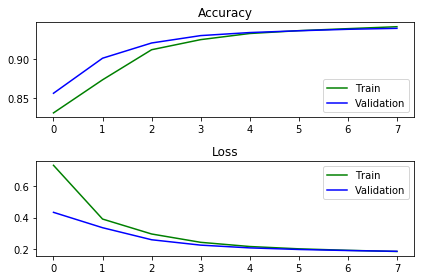

In [41]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history1_bilstm_200.history["acc"], color="g", label="Train")
plt.plot(history1_bilstm_200.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history1_bilstm_200.history["loss"], color="g", label="Train")
plt.plot(history1_bilstm_200.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# Сравнение

Для каждой архитектуры с каждым из выбранных размеров слоя Embedding приводятся следующие показатели:  
* Best epoch accuracy - показатель точности в лучшей точке
* Total accuracy - финальное значение точности  
* Accuracy without paddings - точность при удалении паддингов (дополнении последовательностей до максимальной длины): обычно более "реальный" показатель

## Голландский язык

SimpleRNN

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9272              | 0.907          | 0.840                     |
| 100            | 0.9284              | 0.907          | 0.840                     |
| 200            | 0.9299              | 0.907          | 0.840                     |

LSTM

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9280              | 0.907          | 0.840                     |
| 100            | 0.9295              | 0.907          | 0.840                     |
| 200            | 0.9322              | 0.910          | 0.845                     |

GRU

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9295              | 0.909          | 0.843                     |
| 100            | 0.9317              | 0.910          | 0.846                     |
| 200            | 0.9336              | 0.912          | 0.849                     |

Biderictional LSTM

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9403              | 0.922          | 0.866                     |
| 100            | 0.9448              | 0.925          | 0.871                     |
| 200            | 0.9475              | 0.926          | 0.873                     |

## Словацкий язык

SimpleRNN

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9055              | 0.858          | 0.677                     |
| 100            | 0.9186              | 0.868          | 0.700                     |
| 200            | 0.9242              | 0.870          | 0.705                     |

LSTM

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9118              | 0.862          | 0.687                     |
| 100            | 0.9203              | 0.867          | 0.700                     |
| 200            | 0.9248              | 0.870          | 0.707                     |

GRU

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9228              | 0.870          | 0.707                     |
| 100            | 0.9260              | 0.870          | 0.706                     |
| 200            | 0.9288              | 0.873          | 0.713                     |

Bidirectional LSTM

| Embegging size | Best epoch accuracy | Total accuracy | Accuracy without paddings |
|----------------|---------------------|----------------|---------------------------|
| 64             | 0.9316              | 0.883          | 0.735                     |
| 100            | 0.9363              | 0.889          | 0.747                     |
| 200            | 0.9414              | 0.891          | 0.753                     |

# Общие выводы

1. Несмотря на то, что выбранные языки не являются родственными и имеют мало общих черт (разный тип в морфологической типологии, разные языковые семьи, разный уровень свободы порядка слов и т.д.), нейронные сети разных архитектур справляются с частеречной разметкой на хорошем уровне для обоих языков. Безусловно, относительно свободный порядок слов словацкого языка влияет на точность предсказания, в то время как голландский язык с несвободным порядком слов более удобен для обучения модели.  
2. Как и ожидалось, худшим образом себя проявила модель SimpleRNN (особенно в словацком языке). Предсказание долгосрочных зависимостей - важная часть работы с естественными языками (особенно с теми, у которых порядок слов относительно свободный, - см. словацкий), а SimpleRNN с этим справляется плохо из-за проблем с затухающим/взрывным градиентом.
3. Модели LSTM и GRU проявили себя практически одинаково (показатели GRU чуть-чуть лучше), что ожидаемо, поскольку они являются улучшенными архитектурами обычных RNN и решают проблемы с градиентом (см. выше)
4. (Снова) ожидаемо лучше всех себя проявила модель двунаправленной LSTM, посколько заложенный в данной архитектуре подход наиболее глубоко отражает основную идею работы с естественным языком: при предсказании нужно учитывать и правый и левый контекст. Правда, показатели данной модели на словацком языке хуже, чем на голландском, но здесь, вероятно, снова влияет особенность порядка слов. Тем не менее, долгое время обучения данной модели компенсируется ее хорошей предсказательной способностью.
5. Изменение размера слоя Embedding улучшает предсказательную способность модели, хоть и не всегда. Зачастую именно размер 200 давал значительный прирост точности, в то время как размер 64 и 100 не сильно отличались по уровню улучшения показателей работы модели.